# Survival Regression with `estimators.SurvivalModel`
<hr>

Author: ***Willa Potosnak***  &lt;wpotosna@andrew.cmu.edu&gt;

<div style=" float: right;">
<img align="right" src="https://ndownloader.figshare.com/files/34052981" width="25%"/>
<img align="right" src="https://www.cs.cmu.edu/~chiragn/auton_logo.png" width="25%"/>
</div>

# Contents


### 1. [Introduction](#introduction) 
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  1.1 [The SUPPORT Dataset](#support)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  1.2 [Preprocessing the Data](#preprocess)

### 5. [Deep Cox Mixtures (DCM)](#dcm)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   5.1 [Fit DCM Model](#fitdcm)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   5.2 [Evaluate DCM Model](#evaldcm)

<hr>

<a id="introduction"></a>

## 1. Introduction

The `SurvivalModels` class offers a steamlined approach to train two `auton-survival` models and three baseline survival models for right-censored time-to-event data. The fit method requires the same inputs across all five models, however, model parameter types vary and must be defined and tuned for the specified model.

### Native `auton-survival` Models
 
* **Deep Cox Mixtures (DCM)**

 
$\textbf{Hyperparameter tuning}$ and $\textbf{model evaluation}$ can be performed using the following metrics, among others.

* $\textbf{Brier Score (BS)}$: the Mean Squared Error (MSE) around the probabilistic prediction at a certain time horizon. The Brier Score can be decomposed into components that measure both discriminative performance and calibration.

\begin{align}
\text{BS}(t) = \mathop{\mathbf{E}}_{x\sim\mathcal{D}}\big[ ||\mathbf{1}\{ T > t \} - \widehat{\mathbf{P}}(T>t|X)\big)||_{_\textbf{2}}^\textbf{2}  \big]
\end{align}

* $\textbf{Integrated Brier Score (IBS)}$: the integral of the time-dependent $\textbf{BS}$ over the interval $[t_1; t_{max}]$ where the weighting function is $w(t)= \frac{t}{t_{max}}$.

\begin{align}
\text{IBS} = \int_{t_1}^{t_{max}} \mathrm{BS}^{c}(t)dw(t)
\end{align}

* $\textbf{Area under ROC Curve (ROC-AUC)}$: survival model evaluation can be treated as binary classification to compute the **True Positive Rate (TPR)** and **False Positive Rate (FPR)** dependent on time, $t$. ROC-AUC is used to assess how well the model can distinguish samples that fail by a given time, $t$ from those that fail after this time.

\begin{align}
\widehat{AUC}(t) = \frac{\sum_{i=1}^{n} \sum_{j=1}^{n}I(y_j>t)I(y_i \leq t)w_iI(\hat{f}(x_j) \leq \hat{f}(x_i))}{(\sum_{i=1}^{n} I(y_i > t))(\sum_{i=1}^{n}I(y_i \leq t)w_i)}
\end{align}

* $\textbf{Time Dependent Concordance Index (C$^{td}$)}$: estimates ranking ability by exhaustively comparing relative risks across all pairs of individuals in the test set. We employ the ‘Time Dependent’ variant of Concordance Index that truncates the pairwise comparisons to the events occurring within a fixed time horizon. 

\begin{align}
C^{td}(t) = P(\hat{F}(t|x_i) > \hat{F} (t|x_j)|\delta_i = 1, T_i < T_j, T_i \leq t)
\end{align}


<a id="support"></a>

### 1.1. The SUPPORT Dataset

*For the original datasource, please refer to the following [website](https://biostat.app.vumc.org/wiki/Main/SupportDesc).*

Data features $x$ are stored in a pandas dataframe with rows corresponding to individual samples and columns as covariates. Data outcome consists of 'time', $t$, and 'event', $e$, that correspond to the time to event and the censoring indicator, respectively. 

In [1]:
import pandas as pd
import sys
sys.path.append('../')

from auton_survival.datasets import load_dataset
import warnings

from auton_survival.preprocessing import Preprocessor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt

%matplotlib inline

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline

set_config(display="text")  # displays text representation of estimators

warnings.filterwarnings("ignore")

In [2]:
# Load the SUPPORT dataset
outcomes, features = load_dataset(dataset='SUPPORT')

# Identify categorical (cat_feats) and continuous (num_feats) features
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls']

# Let's take a look at the features
display(features.head(5))

# Let's take a look at the outcomes
display(outcomes.head(5))

,sex,dzgroup,dzclass,income,race,ca,age,num.co,meanbp,wblc,...,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls
0,male,Lung Cancer,Cancer,$11-$25k,other,metastatic,62.84998,0,97.0,6.000000,...,1.799805,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0
1,female,Cirrhosis,COPD/CHF/Cirrhosis,$11-$25k,white,no,60.33899,2,43.0,17.097656,...,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0
2,female,Cirrhosis,COPD/CHF/Cirrhosis,under $11k,white,no,52.74698,2,70.0,8.500000,...,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0
3,female,Lung Cancer,Cancer,under $11k,white,metastatic,42.38498,2,75.0,9.099609,...,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0
4,female,ARF/MOSF w/Sepsis,ARF/MOSF,NaN,white,no,79.88495,1,59.0,13.500000,...,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0


,event,time
0,0,2029
1,1,4
2,1,47
3,1,133
4,0,2029


<a id="preprocess"></a>
### 1.2. Preprocess the Data

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(features, outcomes, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
print(f'Number of test data points: {len(x_te)}')

Number of training data points: 5463
Number of validation data points: 1821
Number of test data points: 1821


In [4]:
from auton_survival.preprocessing import Preprocessor

# Fit the imputer and scaler to the training data and transform the training, validation and test data
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean') 
transformer = preprocessor.fit(features, cat_feats=cat_feats, num_feats=num_feats,
                                one_hot=True, fill_value=-1)
x_tr = transformer.transform(x_tr)
x_val = transformer.transform(x_val)
x_te = transformer.transform(x_te)

<a id="dcm"></a>
## 5. Deep Cox Mixtures (DCM)

<b>DCM</b> [2] generalizes the proportional hazards assumption via a mixture model, by assuming that there are latent groups and within each, the proportional hazards assumption holds. DCM allows the hazard ratio in each latent group, as well as the latent group membership, to be flexibly modeled by a deep neural network.

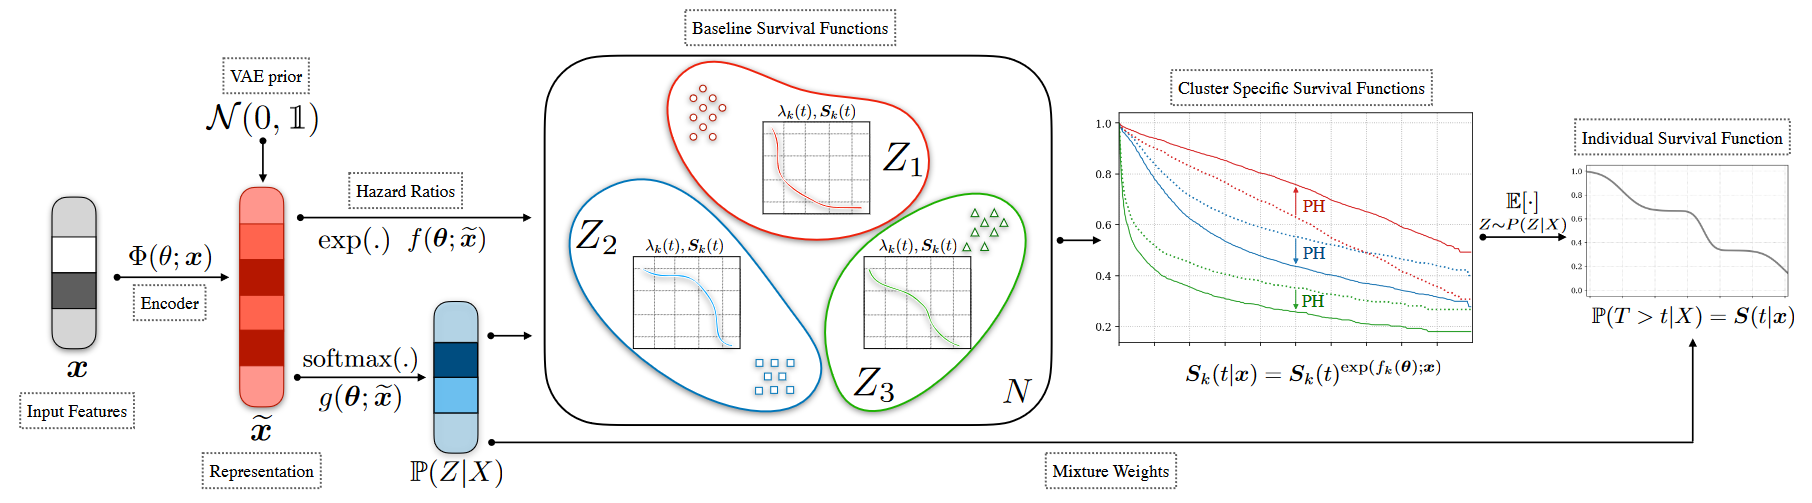

<b>Figure B:</b> DCM works by generating representation of the individual covariates, $x$, using an encoding neural network. The output representation, $xe$, then interacts with linear functions, $f$ and $g$, that determine the proportional hazards within each cluster $Z ∈ {1, 2, ...K}$ and the mixing weights $P(Z|X)$ respectively. For each cluster, baseline survival rates $Sk(t)$ are estimated non-parametrically. The final individual survival curve $S(t|x)$ is an average over the cluster specific individual survival curves weighted by the mixing probabilities $P(Z|X = x)$.


*For full details on Deep Cox Mixtures (DCM), please refer to the following paper*:

[2] [Nagpal, C., Yadlowsky, S., Rostamzadeh, N., and Heller, K. (2021c). Deep cox mixtures for survival regression. In
Machine Learning for Healthcare Conference, pages 674–708. PMLR.](https://arxiv.org/abs/2101.06536)

<a id="fitdcm"></a>
### 5.1. Fit DCM Model

In [5]:
print(x_tr.dtypes)
#print(y_tr)

# Define parameters for tuning the model
param_grid = {'k' : [2,3],
              'learning_rate' : [1e-3,1e-4]
              # 'layers' : [[100], [100, 100]],
             }

alphas = [[0], [0.001], [0.1], [1], [10], [100], [1000]]
params = ParameterGrid(param_grid)
weights = []

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for alpha in alphas:
    for param in params:
        # model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'], layers=param['layers'], alphas=alphas)
        model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'],layers=[] ,alphas=alpha)
        
        # The fit method is called to train the model
        model.fit(x_tr, y_tr)
    
        # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
        predictions_val = model.predict_survival(x_val, times)
        metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
        models.append([metric_val, model])
    weight = model._model.torch_model[0].expert.weight
    weights.append(weight)
    
print(weights)
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

age                           float64
num.co                        float64
meanbp                        float64
wblc                          float64
hrt                           float64
resp                          float64
temp                          float64
pafi                          float64
alb                           float64
bili                          float64
crea                          float64
sod                           float64
ph                            float64
glucose                       float64
bun                           float64
urine                         float64
adlp                          float64
adls                          float64
sex_male                         bool
dzgroup_CHF                      bool
dzgroup_COPD                     bool
dzgroup_Cirrhosis                bool
dzgroup_Colon Cancer             bool
dzgroup_Coma                     bool
dzgroup_Lung Cancer              bool
dzgroup_MOSF w/Malig             bool
dzclass_COPD

 76%|███████▌  | 38/50 [00:15<00:04,  2.48it/s]

[Parameter containing:
tensor([[ 0.0881, -0.1019, -0.1256, -0.0344, -0.0654,  0.0173,  0.0060, -0.0563,
          0.0919, -0.0477,  0.0628, -0.0503, -0.1363, -0.0738,  0.0748,  0.0541,
         -0.0475,  0.0006, -0.1185,  0.0464,  0.0886,  0.0475, -0.0615,  0.1335,
          0.2028,  0.0280, -0.0847,  0.1272,  0.0688, -0.0603, -0.1575, -0.1158,
          0.0062, -0.0186,  0.1352,  0.0096, -0.1173, -0.1236],
        [-0.1156,  0.0440,  0.1123,  0.0313, -0.1098,  0.0603,  0.1255, -0.1085,
         -0.0695,  0.0702, -0.0607, -0.1443,  0.0742, -0.1093, -0.0232, -0.0890,
          0.1345,  0.0656,  0.0865, -0.1720,  0.0828,  0.0038, -0.0881,  0.0531,
         -0.0640,  0.0554,  0.0191, -0.0318,  0.2008,  0.0434, -0.0263,  0.0354,
         -0.0374, -0.0375, -0.0940,  0.0931,  0.0404,  0.0886],
        [ 0.1437,  0.1521,  0.1210, -0.1155,  0.0652, -0.0259,  0.0368, -0.0281,
          0.0113, -0.1063,  0.0968,  0.1630, -0.0187, -0.0954, -0.1241, -0.0309,
          0.0278,  0.0664,  0.0435,  0.

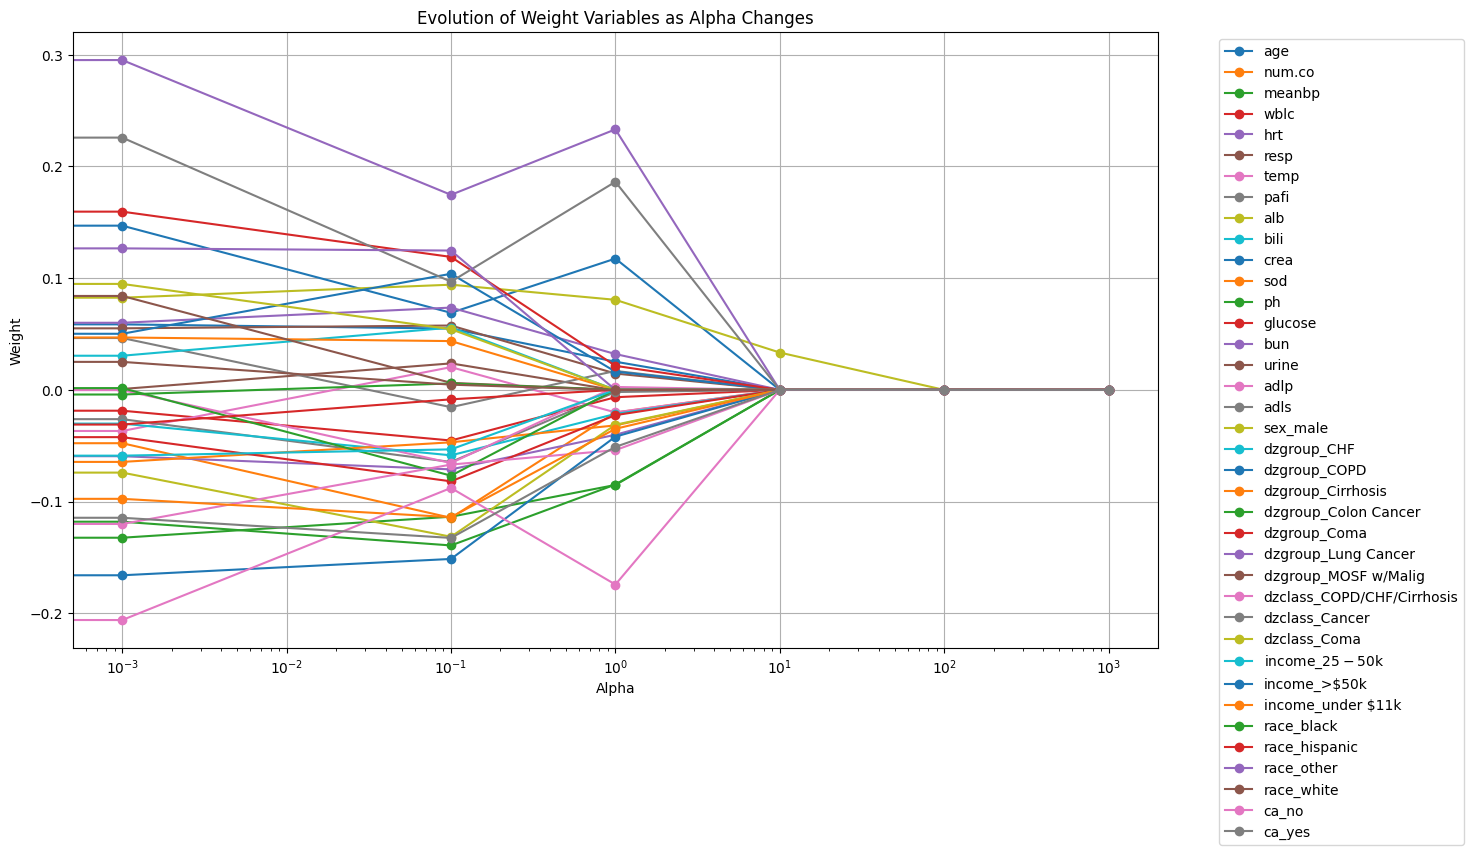

In [6]:
import matplotlib.pyplot as plt

flat_alphas = [alpha for sublist in alphas for alpha in sublist]

new_weights = []
for w in weights:
    new_weights.append(w.detach().numpy())

wxd = np.array(new_weights) 

plt.figure(figsize=(14, 8))
for i in range(len(x_tr.columns)):
    plt.plot(alphas, wxd[:, 0, i], marker='o', label=x_tr.columns[i])

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Weight')
plt.title('Evolution of Weight Variables as Alpha Changes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Ajuste la légende pour éviter le chevauchement
plt.grid(True)
plt.show()

<a id="evaldcm"></a>
### 5.2. Evaluate DCM Model

Compute the Brier Score and time-dependent concordance index for the test set. See notebook introduction for more details.

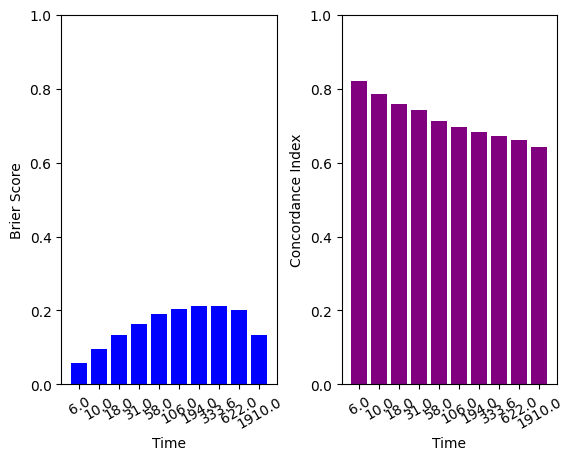

In [7]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

#### Cox - Cox L1

In [46]:
outcomes, features = load_dataset(dataset='SUPPORT')

#combine the features and outcomes
data = pd.concat([features, outcomes], axis=1)
data

,sex,dzgroup,dzclass,income,race,ca,age,num.co,meanbp,wblc,...,crea,sod,ph,glucose,bun,urine,adlp,adls,event,time
0,male,Lung Cancer,Cancer,$11-$25k,other,metastatic,62.84998,0,97.0,6.000000,...,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,0,2029
1,female,Cirrhosis,COPD/CHF/Cirrhosis,$11-$25k,white,no,60.33899,2,43.0,17.097656,...,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,1,4
2,female,Cirrhosis,COPD/CHF/Cirrhosis,under $11k,white,no,52.74698,2,70.0,8.500000,...,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0,1,47
3,female,Lung Cancer,Cancer,under $11k,white,metastatic,42.38498,2,75.0,9.099609,...,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0,1,133
4,female,ARF/MOSF w/Sepsis,ARF/MOSF,NaN,white,no,79.88495,1,59.0,13.500000,...,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0,0,2029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,male,ARF/MOSF w/Sepsis,ARF/MOSF,NaN,white,no,66.07300,1,109.0,7.399414,...,1.099854,131.0,7.459961,188.0,21.0,NaN,NaN,0.0,0,350
9101,female,Coma,Coma,NaN,white,no,55.15399,1,43.0,NaN,...,5.899414,135.0,7.289062,190.0,49.0,0.0,NaN,0.0,0,347
9102,male,ARF/MOSF w/Sepsis,ARF/MOSF,NaN,white,no,70.38196,1,111.0,8.398438,...,2.699707,139.0,7.379883,189.0,60.0,3900.0,NaN,NaN,0,346
9103,male,MOSF w/Malig,ARF/MOSF,NaN,white,yes,47.01999,1,99.0,7.599609,...,3.500000,135.0,7.469727,246.0,55.0,NaN,NaN,0.0,1,7


<Axes: xlabel='timeline'>

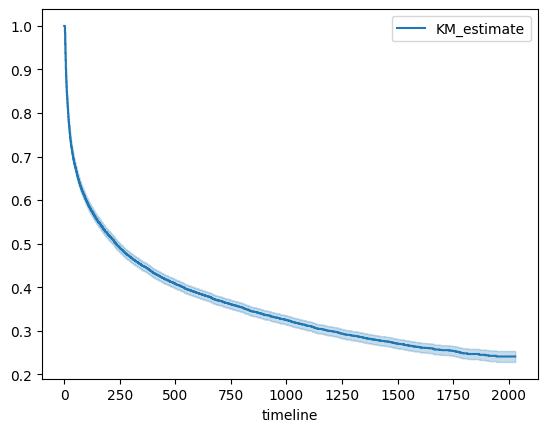

In [76]:
# Import the KaplanMeierFitter class from lifelines
from lifelines import KaplanMeierFitter

# Fit the Kaplan-Meier estimator to the data
kmf = KaplanMeierFitter()
kmf.fit(durations = data['time'], event_observed = data['event'])
kmf.plot_survival_function() # Plot the survival function

Text(0.5, 1.0, 'Survival of different gender group')

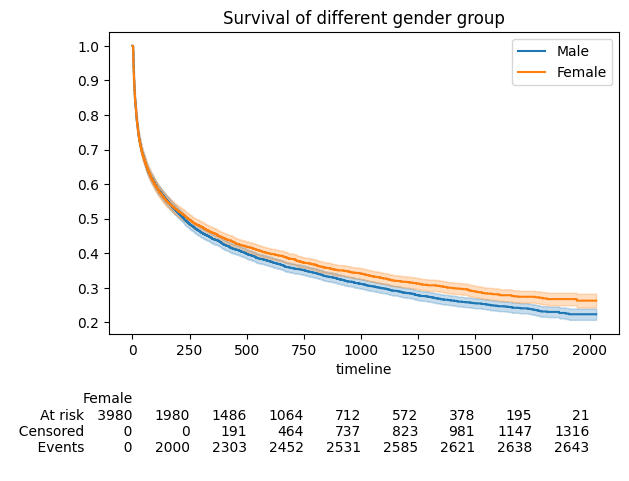

In [77]:
import matplotlib.pyplot as plt

# Plot the survival function for different gender groups
ax = plt.subplot(111)
m = (data["sex"] == "male")
kmf.fit(durations = data['time'][m], event_observed = data['event'][m], label = "Male")
kmf.plot_survival_function(ax = ax)
kmf.fit(data['time'][~m], event_observed = data['event'][~m], label = "Female")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title("Survival of different gender group")

In [47]:
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls']

In [48]:
#preprocess the data
y = data[["event","time"]]
#transform event columns to boolean
y["event"] = y["event"].astype(bool)

#transform y to an array
y = y.to_records(index=False)

data = data.drop(columns=["event","time"])

from auton_survival.preprocessing import Preprocessor
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat='mean')
transformer = preprocessor.fit(data, cat_feats=cat_feats, num_feats=num_feats, one_hot=True, fill_value=-1)
x_tr = transformer.transform(data)
x_tr

,age,num.co,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,...,dzclass_Coma,income_$25-$50k,income_>$50k,income_under $11k,race_black,race_hispanic,race_other,race_white,ca_no,ca_yes
0,0.012772,-1.390013,0.449837,-6.931821e-01,-0.892283,-0.138967,-0.881504,1.569019e+00,-1.655686e+00,-5.238337e-01,...,False,False,False,False,False,False,True,False,False,False
1,-0.148262,0.097711,-1.500702,5.187096e-01,0.470382,1.114591,-2.005013,-1.495658e+00,-6.389701e-16,9.880260e-17,...,False,False,False,False,False,False,False,True,True,False
2,-0.635153,0.097711,-0.525432,-4.201759e-01,-0.290175,0.487812,0.235766,-8.319880e-02,-6.389701e-16,-7.892740e-02,...,False,False,False,True,False,False,False,True,True,False
3,-1.299688,0.097711,-0.344827,-3.546971e-01,-0.290175,0.905665,-1.680444,-3.003564e-16,-6.389701e-16,9.880260e-17,...,False,False,False,True,False,False,False,True,False,False
4,1.105258,-0.646151,-0.922764,1.258366e-01,0.470382,-0.347893,0.635237,-6.997670e-01,-6.389701e-16,9.880260e-17,...,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,0.219471,-0.646151,0.883291,-5.403626e-01,0.216863,-0.138967,-1.124933,4.276908e-01,1.077955e+00,-4.793410e-01,...,False,False,False,False,False,False,False,True,True,False
9101,-0.480786,-0.646151,-1.500702,1.939826e-16,-3.078884,-1.601451,1.190748,-2.222321e-01,-6.389701e-16,9.880260e-17,...,True,False,False,False,False,False,False,True,True,False
9102,0.495813,-0.646151,0.955533,-4.312668e-01,-0.448624,0.069960,-0.325992,-6.290945e-01,-6.389701e-16,-4.793410e-01,...,False,False,False,False,False,False,False,True,True,False
9103,-1.002436,-0.646151,0.522080,-5.185008e-01,0.407002,0.069960,-0.563174,1.997678e+00,-2.518775e+00,-4.793410e-01,...,False,False,False,False,False,False,False,True,False,True


In [40]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.0001)

#combine the features and outcomes
data = pd.concat([x_tr, outcomes], axis=1)
cph.fit(data, duration_col='time', event_col='event')

cph.print_summary()  # access the individual results using cph.summary

<lifelines.CoxPHFitter: fitted with 9105 total observations, 2904 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 9105
number of events observed = 6201
   partial log-likelihood = -52181.73
         time fit was run = 2024-05-14 09:57:32 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                   
age                         0.25      1.28      0.01            0.22            0.28                1.25                1.32
num.co                      0.12      1.13      0.02            0.09            0.15                1.10                1.16
meanbp                     -0.09      0.92      0.01           -0.12           -0.06                0.89                0.94
wblc                        0.01      1.01      0.01           -0.01            0.04                0.99                1.04
hrt                         0.06      1.06      0.01            0.03            0.09                1.03                1.09
resp                        0.03      1.03      0.01            0.00            0.06                1.00                1.06
temp                       -0.03      0.97      0.01           -0.06           -0.01                0.94                0.99
pafi                       -0.03      0.97      0.01           -0.05           -0.00                0.95                1.00
alb                         0.00      1.00      0.01           -0.03            0.03                0.97                1.03
bili                        0.12      1.12      0.01            0.09            0.14                1.10                1.15
crea                        0.07      1.07      0.01            0.04            0.10                1.04                1.10
sod                        -0.01      0.99      0.01           -0.04            0.02                0.97                1.02
ph                         -0.02      0.98      0.01           -0.04            0.01                0.96                1.01
glucose                     0.01      1.01      0.01           -0.02            0.03                0.98                1.03
bun                        -0.05      0.95      0.02           -0.08           -0.02                0.92                0.98
urine                       0.02      1.02      0.01           -0.00            0.05                1.00                1.05
adlp                        0.04      1.04      0.01            0.01            0.06                1.01                1.06
adls                        0.13      1.14      0.01            0.11            0.16                1.11                1.17
sex_male                    0.12      1.12      0.03            0.07            0.17                1.07                1.18
dzgroup_CHF                -0.20      0.82      1.49           -3.13            2.73                0.04               15.35
dzgroup_COPD               -0.21      0.81      1.49           -3.14            2.72                0.04               15.15
dzgroup_Cirrhosis           0.20      1.22      1.49           -2.73            3.13                0.07               22.86
dzgroup_Colon Cancer        0.03      1.03      2.00           -3.89            3.95                0.02               51.92
dzgroup_Coma                0.52      1.68      3.00           -5.35            6.39                0.00              597.10
dzgroup_Lung Cancer         0.29      1.34      2.00           -3.63            4.21                0.03               67.58
dzgroup_MOSF w/Malig        0.85      2.34      0.06            0.73            0.97                2.07                2.64
dzclass_COPD/CHF/Cirrhosis -0.16      0.85      1.49           -3.09  

In [50]:
data = x_tr
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(data, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

In [122]:
# Plot the coefficients
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

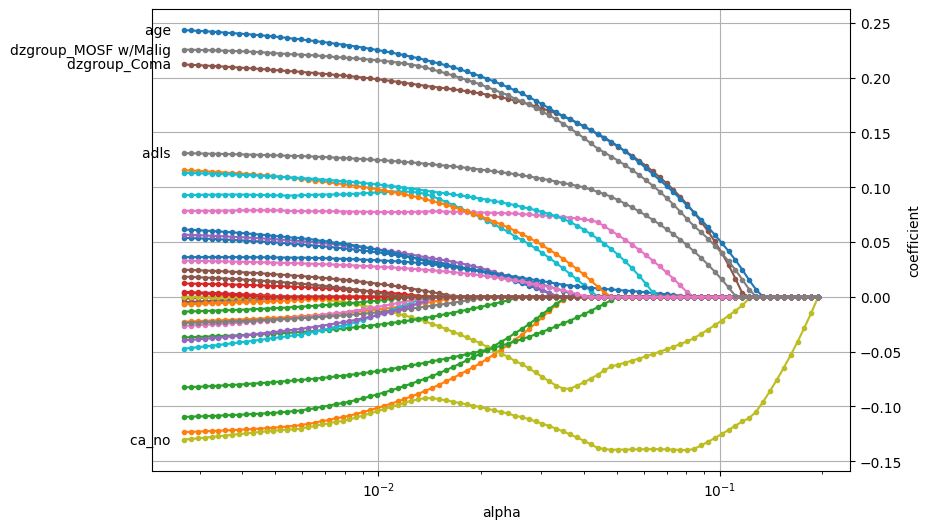

In [123]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=data.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=5)

In [178]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(data, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1,
                                        max_iter=100))])

In [179]:
# Perform grid search with cross-validation
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(data, y)

cv_results = pd.DataFrame(gcv.cv_results_)

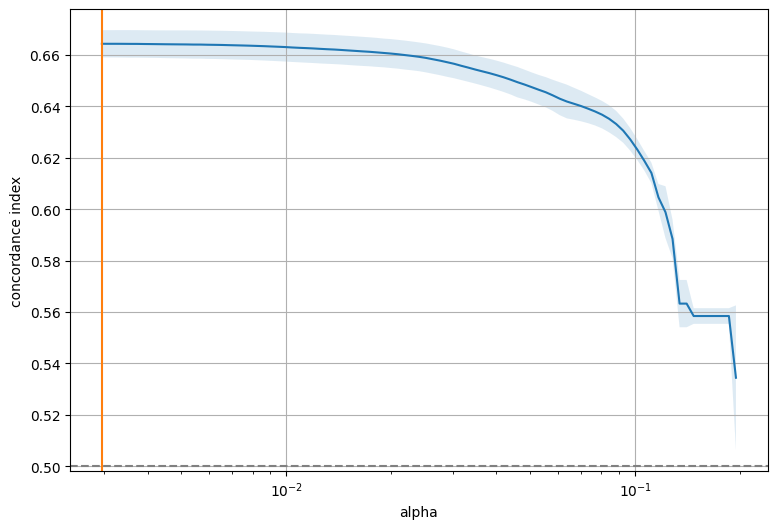

In [180]:
# Plot the results
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 34


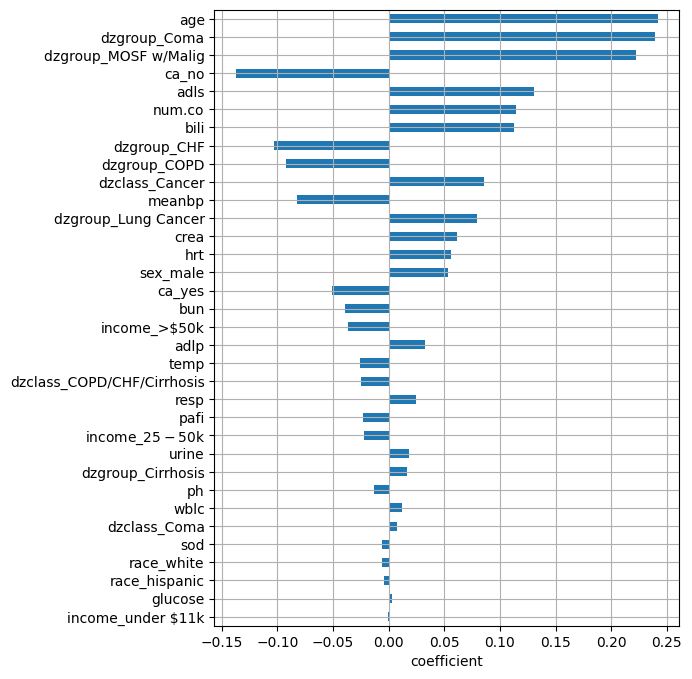

In [181]:
# Display the best model
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=data.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

### PBC

In [2]:
#load PBC
data, time, event = load_dataset(dataset='PBC')
data

,drug_placebo,sex_male,ascites_Yes,hepatomegaly_Yes,spiders_Yes,edema_edema despite diuretics,edema_edema no diuretics,histologic_2,histologic_3,histologic_4,age,serBilir,serChol,albumin,alkaline,SGOT,platelets,prothrombin,time,event
0,0,0,1,1,1,1,0,0,0,1,0.248058,2.015877,-3.568804e-01,-1.570646,0.281173,0.195488,-0.447383,0.813132,1.095170,1
1,0,0,1,1,1,1,0,0,0,1,0.248058,3.281890,-1.517173e-16,-0.894575,0.192493,-1.485263,-0.519077,0.136768,0.569489,1
2,0,0,0,1,1,0,0,0,1,0,1.292856,-0.478914,-1.108451e-01,1.491559,5.030580,-0.116943,-0.129880,-0.269050,14.152338,0
3,0,0,0,1,1,0,0,0,1,0,1.292856,-0.534768,-1.517173e-16,0.417798,0.606612,0.214616,-0.467867,0.001495,13.654036,0
4,0,0,0,1,1,0,0,0,1,0,1.292856,-0.497532,-1.517173e-16,0.318376,0.275317,0.274552,-0.744401,0.407314,13.152995,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,1,0,0,0,1,0,0,1,0,0,-1.962482,0.507832,1.533391e+00,0.795603,0.613305,0.169983,-0.344963,-0.133778,3.989158,0
1941,1,0,0,0,0,0,0,1,0,0,-1.962482,0.340271,-1.517173e-16,-0.377580,0.247709,0.016956,-0.457625,-0.066141,3.425145,0
1942,1,0,0,0,0,0,0,1,0,0,-1.962482,0.694010,-5.083648e-02,0.338261,0.322167,0.552551,-0.877548,0.474950,2.921367,0
1943,1,0,0,0,1,0,1,1,0,0,-1.962482,2.350998,2.205487e+00,-0.099197,0.901934,0.641817,-0.979968,1.354223,1.867265,0


#### Cox - Cox L1

In [3]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.0001)

cph.fit(data, duration_col='time', event_col='event')

cph.print_summary()  # access the individual results using cph.summary

<lifelines.CoxPHFitter: fitted with 1945 total observations, 1220 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1945
number of events observed = 725
   partial log-likelihood = -4473.59
         time fit was run = 2024-05-14 13:09:21 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
drug_placebo                   0.03      1.03      0.08           -0.12            0.18                0.88                1.20
sex_male                       0.87      2.38      0.10            0.67            1.06                1.96                2.90
ascites_Yes                   -0.42      0.66      0.13           -0.67           -0.18                0.51                0.84
hepatomegaly_Yes               0.09      1.10      0.09           -0.08            0.27                0.93                1.31
spiders_Yes                    0.01      1.01      0.08           -0.15            0.17                0.86                1.19
edema_edema despite diuretics  1.13      3.09      0.14            0.86            1.39                2.37                4.03
edema_edema no diuretics       0.49      1.63      0.10            0.29            0.68                1.34                1.97
histologic_2                   0.04      1.04      0.27           -0.49            0.57                0.61                1.77
histologic_3                   0.46      1.59      0.25           -0.03            0.96                0.97                2.62
histologic_4                   0.75      2.11      0.25            0.25            1.24                1.28                3.47
age                            0.03      1.03      0.05           -0.06            0.11                0.94                1.12
serBilir                       0.56      1.74      0.04            0.48            0.63                1.62                1.88
serChol                        0.03      1.03      0.05           -0.06            0.12                0.94                1.13
albumin                       -0.63      0.53      0.04           -0.72           -0.55                0.49                0.58
alkaline                       0.06      1.06      0.03           -0.00            0.12                1.00                1.13
SGOT                           0.03      1.03      0.04           -0.05            0.11                0.95                1.12
platelets                     -0.09      0.91      0.04           -0.18           -0.01                0.84                0.99
prothrombin                    0.18      1.20      0.02            0.13            0.23                1.14                1.26

                               cmp to      z      p  -log2(p)
covariate                                                    
drug_placebo                     0.00   0.36   0.72      0.48
sex_male                         0.00   8.68 <0.005     57.81
ascites_Yes                      0.00  -3.36 <0.005     10.33
hepatomegaly_Yes                 0.00   1.08   0.28      1.83
spiders_Yes                      0.00   0.14   0.88      0.18
edema_edema despite diuretics    0.00   8.33 <0.005     53.47
edema_edema no diuretics         0.00   4.95 <0.005     20.36
histologic_2                     0.00   0.15   0.88      0.19
histologic_3                     0.00   1.83   0.07      3.89
histologic_4                     0.00   2.94 <0.005      8.24
age                              0.00   0.56   0.57      0.80
serBilir                         0.00  14.74 <0.005    160.97
serChol                          0.00   0.60   0.55      0.87
albumin                          0.00 -14.21 <0.005    149.78
alkaline           

<Axes: xlabel='log(HR) (95% CI)'>

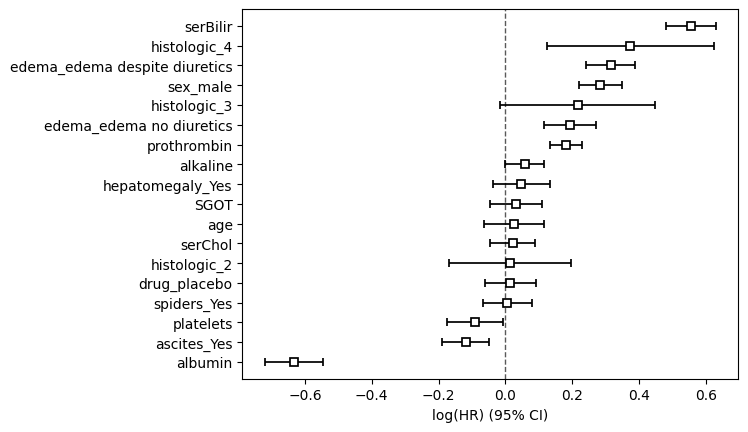

In [15]:
cph.plot() # Plot the coefficients

In [4]:
#dataframe with time and event and drop columns in data
y = data[["event","time"]]
#transform event columns to boolean
y["event"] = y["event"].astype(bool)
#transform y to an array
y = y.to_records(index=False)
y

rec.array([( True,  1.0951703 ), ( True,  0.56948856),
           (False, 14.15233819), ..., (False,  2.92136677),
           (False,  1.86726536), (False,  1.04588764)],
          dtype=[('event', '?'), ('time', '<f8')])

In [5]:
data = data.drop(columns=["time", "event"]) #drop time and event columns

In [6]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(data, y) # Fit the model

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

In [198]:
from sksurv.metrics import concordance_index_censored

# Compute the concordance index
prediction = cox_lasso.predict(data)
result = concordance_index_censored(y["event"], y["time"], prediction)
result[0]

0.83782221920959

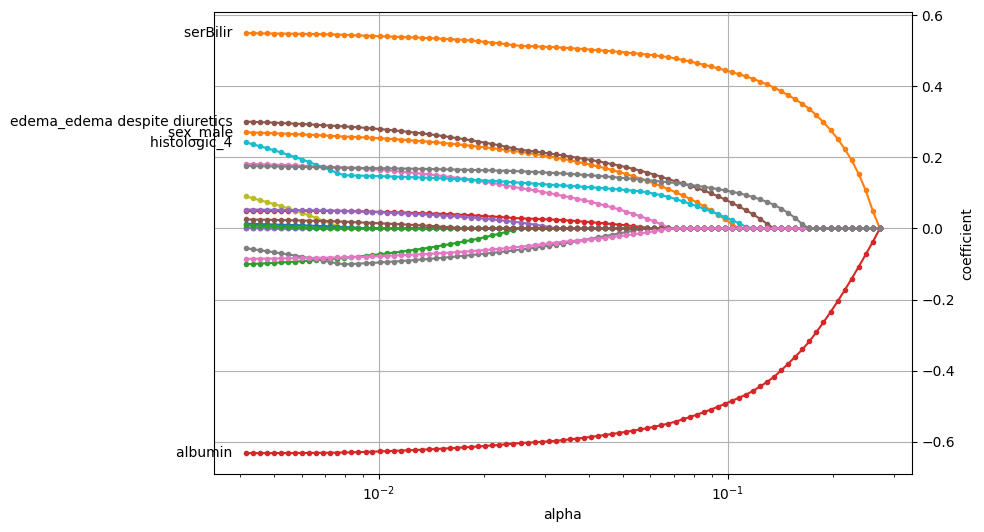

In [199]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=data.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=5)

In [191]:
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(data, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1,
                                        max_iter=100))])

In [192]:
# Perform grid search with cross-validation
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_ 
cv = KFold(n_splits=5, shuffle=True, random_state=0) 
gcv = GridSearchCV( make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1)), param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]}, cv=cv, error_score=0.5, n_jobs=1, ).fit(data, y) 
cv_results = pd.DataFrame(gcv.cv_results_)

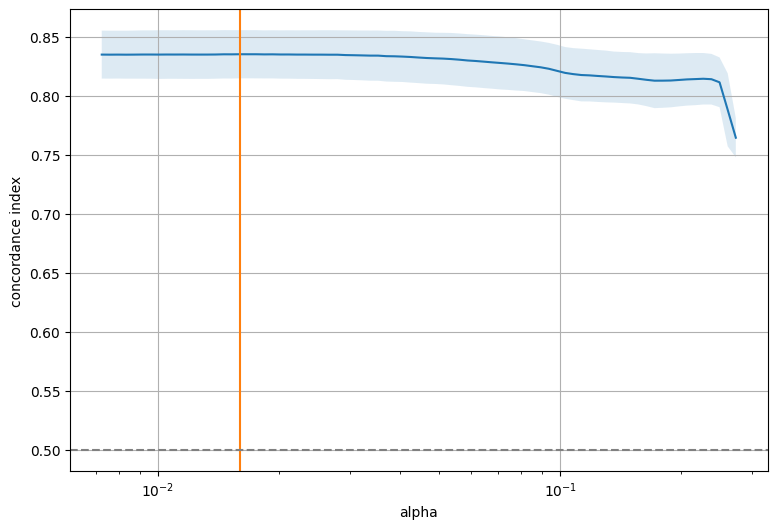

In [193]:
# Plot the results
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 13


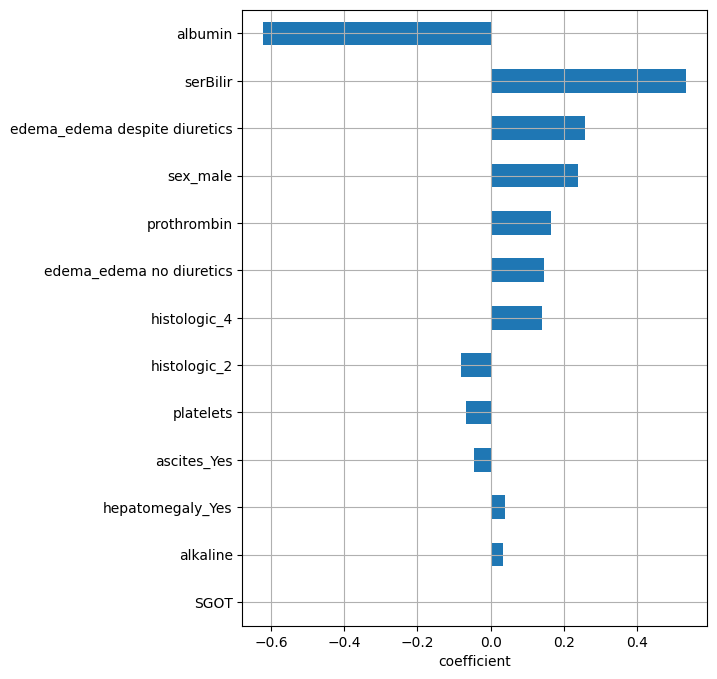

In [143]:
# Display the best model
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=data.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

#### Deep Cox

In [3]:
data, time, event = load_dataset(dataset='PBC')

y = pd.DataFrame(data, columns=["event", "time"])
#drop event and time columns
data = data.drop(columns=["event", "time"])

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(data, y, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
print(f'Number of test data points: {len(x_te)}')

Number of training data points: 1167
Number of validation data points: 389
Number of test data points: 389


In [4]:
print(x_tr.dtypes)
#print(y_tr)

# Define parameters for tuning the model
param_grid = {'k' : [2,3],
              'learning_rate' : [1e-3,1e-4]
              # 'layers' : [[100], [100, 100]],
             }

alphas = [[0], [0.001], [0.1], [1], [10], [100], [1000]]
params = ParameterGrid(param_grid)
weights = []

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for alpha in alphas:
    for param in params:
        # model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'], layers=param['layers'], alphas=alphas)
        model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'],layers=[] ,alphas=alpha)
        
        # The fit method is called to train the model
        model.fit(x_tr, y_tr)
    
        # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
        predictions_val = model.predict_survival(x_val, times)
        metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
        models.append([metric_val, model])
    weight = model._model.torch_model[0].expert.weight
    weights.append(weight)
    
print(weights)
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

drug_placebo                       int32
sex_male                           int32
ascites_Yes                        int32
hepatomegaly_Yes                   int32
spiders_Yes                        int32
edema_edema despite diuretics      int32
edema_edema no diuretics           int32
histologic_2                       int32
histologic_3                       int32
histologic_4                       int32
age                              float64
serBilir                         float64
serChol                          float64
albumin                          float64
alkaline                         float64
SGOT                             float64
platelets                        float64
prothrombin                      float64
dtype: object


  0%|          | 0/50 [00:00<?, ?it/s]

 30%|███       | 15/50 [00:02<00:06,  5.62it/s]

[Parameter containing:
tensor([[-0.1873,  0.0137, -0.1030,  0.0060,  0.1210,  0.1124, -0.0200,  0.0177,
          0.0577, -0.1758, -0.0750,  0.0185, -0.1299, -0.1125,  0.0802,  0.1447,
         -0.0046, -0.0831],
        [ 0.1260, -0.1210, -0.0466,  0.2312,  0.0513,  0.0254,  0.0867, -0.0651,
          0.1940, -0.1833, -0.0596, -0.0318, -0.0924, -0.0675,  0.1446,  0.1366,
          0.0046,  0.2141],
        [-0.1668, -0.1335,  0.1102, -0.0052, -0.2099, -0.1590, -0.1374,  0.1753,
          0.1045,  0.1893, -0.1700, -0.2239, -0.1521,  0.0182, -0.0441, -0.1430,
          0.1648, -0.0699]], requires_grad=True), Parameter containing:
tensor([[-0.1873,  0.0137, -0.1030,  0.0060,  0.1210,  0.1124, -0.0200,  0.0177,
          0.0577, -0.1758, -0.0750,  0.0185, -0.1299, -0.1125,  0.0802,  0.1447,
         -0.0046, -0.0831],
        [ 0.1260, -0.1210, -0.0466,  0.2312,  0.0513,  0.0254,  0.0867, -0.0651,
          0.1940, -0.1833, -0.0596, -0.0317, -0.0924, -0.0675,  0.1446,  0.1366,
          0

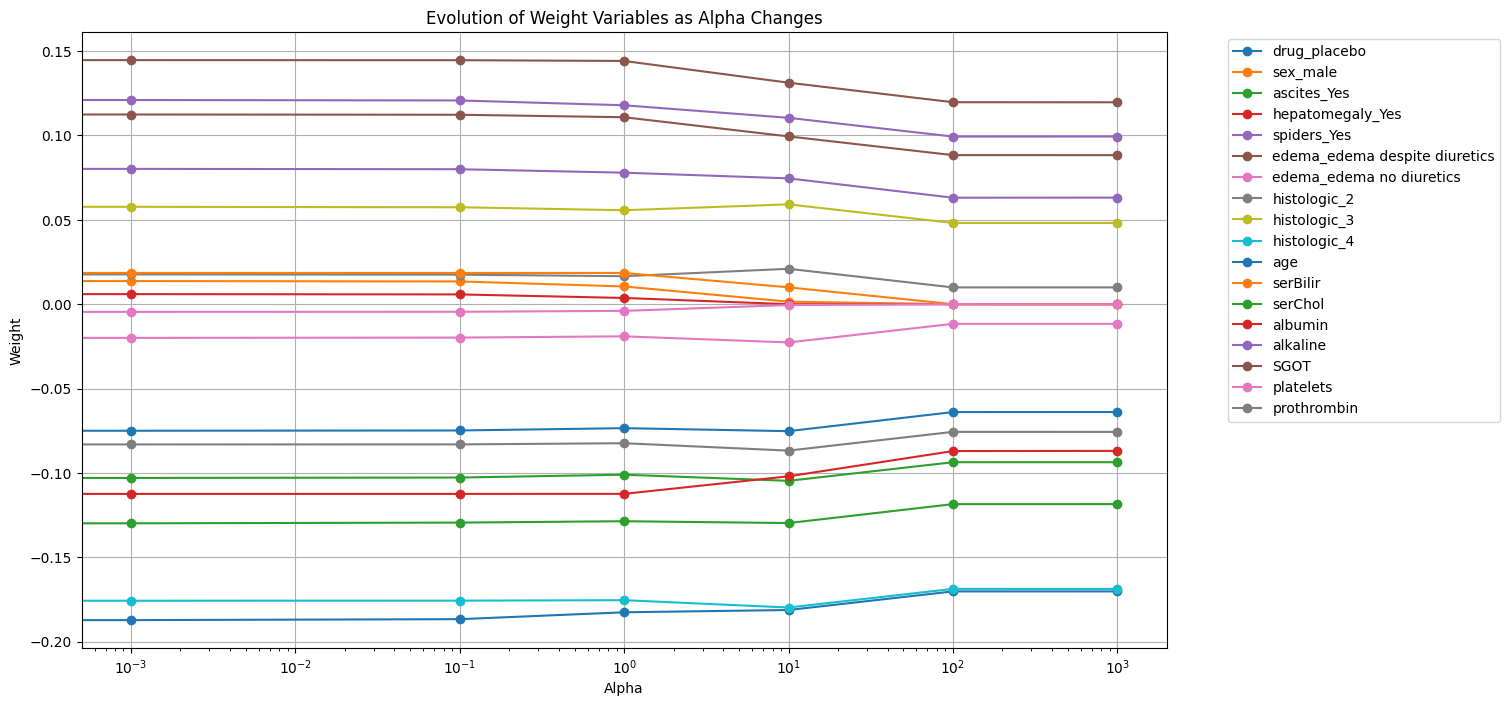

In [5]:
import matplotlib.pyplot as plt

flat_alphas = [alpha for sublist in alphas for alpha in sublist]

new_weights = []
for w in weights:
    new_weights.append(w.detach().numpy())

wxd = np.array(new_weights) 

plt.figure(figsize=(14, 8))
for i in range(len(x_tr.columns)):
    plt.plot(alphas, wxd[:, 0, i], marker='o', label=x_tr.columns[i])

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Weight')
plt.title('Evolution of Weight Variables as Alpha Changes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Ajuste la légende pour éviter le chevauchement
plt.grid(True)
plt.show()

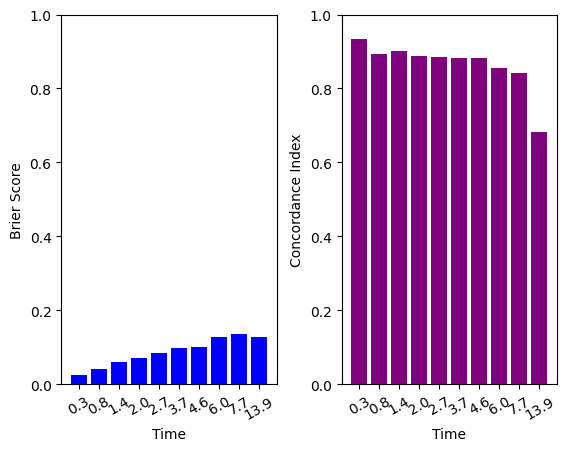

In [18]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

### Framingham

In [2]:
#load Framingham
data, time, event = load_dataset(dataset='FRAMINGHAM')
data

,SEX,CURSMOKE,DIABETES,BPMEDS,educ,PREVCHD,PREVAP,PREVMI,PREVSTRK,PREVHYP,...,SYSBP,DIABP,CIGPDAY,BMI,HEARTRTE,GLUCOSE,LDLC,HDLC,time,event
0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,-1.330143,-1.118195,-0.677015,2.663404e-01,0.258247,-2.850795e-01,-7.161782e-17,-1.490567e-16,8766,0
1,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,-0.672180,-1.461259,-0.677015,4.297019e-16,-0.624378,3.150992e-01,3.271851e-02,-1.175411e+00,4138,0
2,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,-0.672180,-0.174770,-0.677015,6.953510e-01,1.461826,-3.250914e-01,-7.161782e-17,-1.490567e-16,8766,0
3,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,-1.374007,-1.161078,-0.677015,8.659802e-01,0.258247,7.502774e-02,-7.161782e-17,-1.490567e-16,6610,0
4,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,-1.242414,-1.461259,-0.677015,6.392871e-01,0.258247,-5.251510e-01,-7.569408e-01,2.966754e-01,4422,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11622,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,...,-0.452859,-0.089004,-0.677015,-1.634957e+00,-0.544140,-2.109936e-16,-7.161782e-17,-1.490567e-16,6433,0
11623,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.292832,0.511357,-0.677015,-3.347955e-02,-0.945333,-4.851391e-01,-1.141099e+00,-1.239414e+00,4228,0
11624,2.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,-0.145810,0.254060,1.784754,-1.210821e+00,0.659440,-1.650438e-01,-7.161782e-17,-1.490567e-16,8766,0
11625,2.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.073511,-0.346302,0.964164,1.249619e-01,1.060633,-4.500801e-02,-7.161782e-17,-1.490567e-16,6376,0


#### Cox - Cox avec L1

In [33]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()

cph.fit(data, duration_col='time', event_col='event')

cph.print_summary()  # access the individual results using cph.summary

<lifelines.CoxPHFitter: fitted with 11627 total observations, 8100 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 11627
number of events observed = 3527
   partial log-likelihood = -29414.12
         time fit was run = 2024-05-02 07:43:24 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
SEX       -0.21      0.81      0.02           -0.25           -0.17                0.78                0.84
CURSMOKE   0.08      1.09      0.03            0.03            0.14                1.03                1.15
DIABETES   0.11      1.12      0.01            0.08            0.14                1.09                1.15
BPMEDS     0.03      1.03      0.02            0.00            0.06                1.00                1.07
educ      -0.10      0.90      0.02           -0.13           -0.07                0.87                0.94
PREVCHD    0.01      1.01      0.03           -0.06            0.07                0.94                1.08
PREVAP     0.10      1.11      0.03            0.05            0.16                1.05                1.17
PREVMI     0.03      1.03      0.02           -0.01            0.06                0.99                1.07
PREVSTRK   0.07      1.07      0.01            0.04            0.09                1.04                1.09
PREVHYP    0.24      1.28      0.03            0.19            0.30                1.21                1.35
ANGINA    -0.06      0.94      0.02           -0.11           -0.02                0.90                0.98
HOSPMI    -0.08      0.92      0.02           -0.12           -0.05                0.89                0.95
MI_FCHD    0.40      1.49      0.03            0.35            0.45                1.42                1.57
ANYCHD    -0.03      0.97      0.03           -0.10            0.03                0.91                1.03
STROKE     0.01      1.01      0.02           -0.03            0.04                0.97                1.04
CVD        0.15      1.16      0.03            0.09            0.21                1.10                1.23
HYPERTEN  -0.30      0.74      0.02           -0.35           -0.26                0.70                0.77
TOTCHOL   -0.02      0.98      0.02           -0.06            0.02                0.94                1.02
AGE        0.71      2.03      0.02            0.66            0.75                1.94                2.12
SYSBP      0.21      1.23      0.03            0.16            0.26                1.17                1.30
DIABP     -0.02      0.98      0.02           -0.07            0.03                0.94                1.03
CIGPDAY    0.12      1.12      0.03            0.07            0.17                1.07                1.18
BMI       -0.08      0.93      0.02           -0.11           -0.04                0.89                0.96
HEARTRTE   0.07      1.07      0.02            0.03            0.10                1.03                1.11
GLUCOSE    0.03      1.03      0.01            0.00            0.06                1.00                1.06
LDLC      -0.04      0.96      0.02           -0.08            0.00                0.92                1.00
HDLC      -0.00      1.00      0.02           -0.04            0.03                0.96                1.04

           cmp to      z      p  -log2(p)
covariate                                
SEX          0.00 -11.10 <0.005     92.61
CURSMOKE     0.00   3.01 <0.005      8.56
DIABETES     0.00   7.79 <0.005     47.07
BPMEDS       0.00   2.12   0.03      4.89
educ         0.00  -5.65 <0.005     25.92
PREVCHD      0.00   0.18   0.86      0.22
PREVAP       0.00   3.65 <0.005     11.89
PREVMI       0.00   1.52   0.13      2.97
PREVSTRK     0.00   5.41 <0.005     23.89
PREVHYP      0.00   9.09 <0.005     63.1

<Axes: xlabel='log(HR) (95% CI)'>

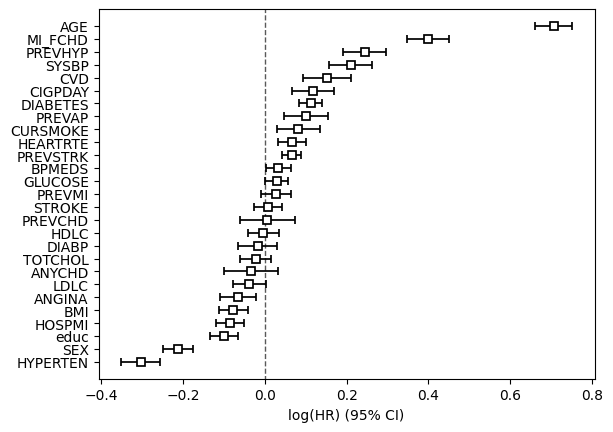

In [34]:
cph.plot() # Plot the coefficients

In [206]:
#dataframe with time and event and drop columns in data
y = data[["event","time"]]
#transform event columns to boolean
y["event"] = y["event"].astype(bool)
#transform y to an array
y = y.to_records(index=False)
y

rec.array([(False, 8766), (False, 4138), (False, 8766), ...,
           (False, 8766), (False, 6376), (False, 4565)],
          dtype=[('event', '?'), ('time', '<i8')])

In [207]:
data = data.drop(columns=["time", "event"]) #drop time and event columns

In [208]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(data, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

In [39]:
cox_lasso.coef_

array([[ 0.        ,  0.        ,  0.        , ..., -0.20159457,
        -0.20203719, -0.20252191],
       [ 0.        ,  0.        ,  0.        , ...,  0.07521285,
         0.07551452,  0.07592896],
       [ 0.        ,  0.        ,  0.        , ...,  0.10875124,
         0.10895961,  0.10923103],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.0266133 ,
         0.02677837,  0.02685432],
       [ 0.        ,  0.        ,  0.        , ..., -0.02711474,
        -0.02760505, -0.02798022],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [40]:
from sksurv.metrics import concordance_index_censored

prediction = cox_lasso.predict(data)
result = concordance_index_censored(y["event"], y["time"], prediction)
result[0] # Compute the concordance index

0.7918250003481282

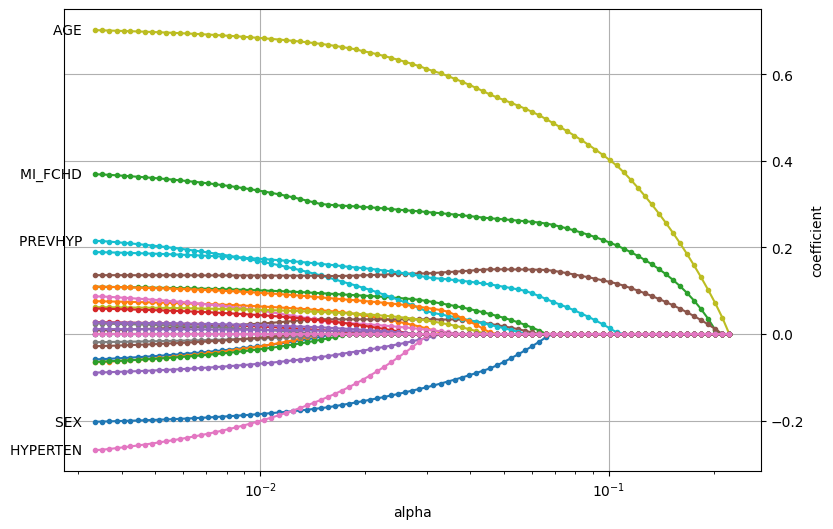

In [41]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=data.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=5)

In [210]:
coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(data, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1,
                                        max_iter=100))])

In [211]:
# Perform grid search with cross-validation
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(data, y)

cv_results = pd.DataFrame(gcv.cv_results_)

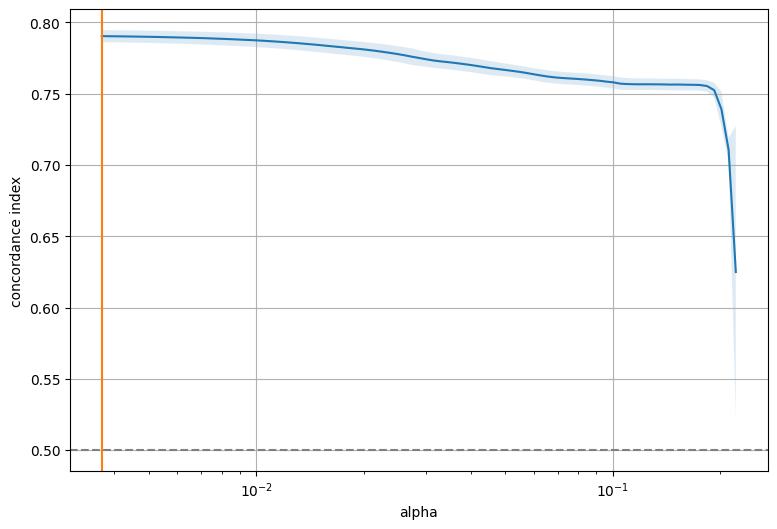

In [212]:
# Plot the results
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 24


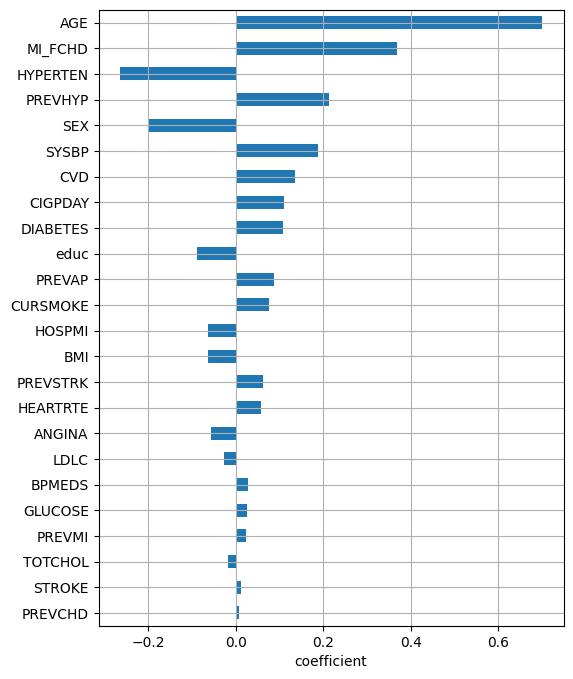

In [213]:
# Display the best model
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=data.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

#### Deep Cox

In [6]:
data, time, event = load_dataset(dataset='FRAMINGHAM')

#transform y to dataframe
y = pd.DataFrame(data, columns=["event", "time"])
#drop event and time columns
data = data.drop(columns=["event", "time"])

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(data, y, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
print(f'Number of test data points: {len(x_te)}')

Number of training data points: 6975
Number of validation data points: 2326
Number of test data points: 2326


In [27]:
print(x_tr.dtypes)
#print(y_tr)

# Define parameters for tuning the model
param_grid = {'k' : [2,3],
              'learning_rate' : [1e-3,1e-4]
              # 'layers' : [[100], [100, 100]],
             }

alphas = [[0], [0.001], [0.1], [1], [10], [100], [1000]]
params = ParameterGrid(param_grid)
weights = []

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for alpha in alphas:
    for param in params:
        # model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'], layers=param['layers'], alphas=alphas)
        model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'],layers=[] ,alphas=alpha)
        
        # The fit method is called to train the model
        model.fit(x_tr, y_tr)
    
        # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
        predictions_val = model.predict_survival(x_val, times)
        metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
        models.append([metric_val, model])
    weight = model._model.torch_model[0].expert.weight
    weights.append(weight)
    
print(weights)
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

SEX         float64
CURSMOKE    float64
DIABETES    float64
BPMEDS      float64
educ        float64
PREVCHD     float64
PREVAP      float64
PREVMI      float64
PREVSTRK    float64
PREVHYP     float64
ANGINA      float64
HOSPMI      float64
MI_FCHD     float64
ANYCHD      float64
STROKE      float64
CVD         float64
HYPERTEN    float64
TOTCHOL     float64
AGE         float64
SYSBP       float64
DIABP       float64
CIGPDAY     float64
BMI         float64
HEARTRTE    float64
GLUCOSE     float64
LDLC        float64
HDLC        float64
dtype: object


  0%|          | 0/50 [00:00<?, ?it/s]

 76%|███████▌  | 38/50 [00:18<00:05,  2.03it/s]

[Parameter containing:
tensor([[-0.2367,  0.0519,  0.0878,  0.0199, -0.1037,  0.1491,  0.1298,  0.0307,
          0.1865,  0.0283, -0.0791,  0.1295,  0.1450, -0.0348, -0.0070,  0.0478,
          0.1285,  0.1044,  0.3599,  0.0416, -0.0660, -0.0167, -0.0068,  0.0311,
          0.0066,  0.0569, -0.0844],
        [-0.2052,  0.0460,  0.0842,  0.1579, -0.0527,  0.0837,  0.0991, -0.0570,
         -0.0094,  0.0716, -0.0542,  0.1037,  0.1956,  0.0501,  0.2074,  0.0504,
          0.0204, -0.0527,  0.0458,  0.0410,  0.1374,  0.0645, -0.0607,  0.0178,
         -0.0414,  0.0050,  0.1096],
        [-0.0511, -0.0219,  0.1619,  0.1565, -0.1207,  0.0062,  0.1066,  0.0601,
         -0.0005, -0.0300, -0.1000,  0.0610,  0.1213,  0.2555,  0.0562,  0.0801,
         -0.1717, -0.0925,  0.2819,  0.2822,  0.0205, -0.0621,  0.0126,  0.1575,
         -0.0306, -0.0541, -0.0213]], requires_grad=True), Parameter containing:
tensor([[-2.3598e-01,  5.1966e-02,  8.8543e-02,  1.9624e-02, -1.0413e-01,
          1.4847e-0

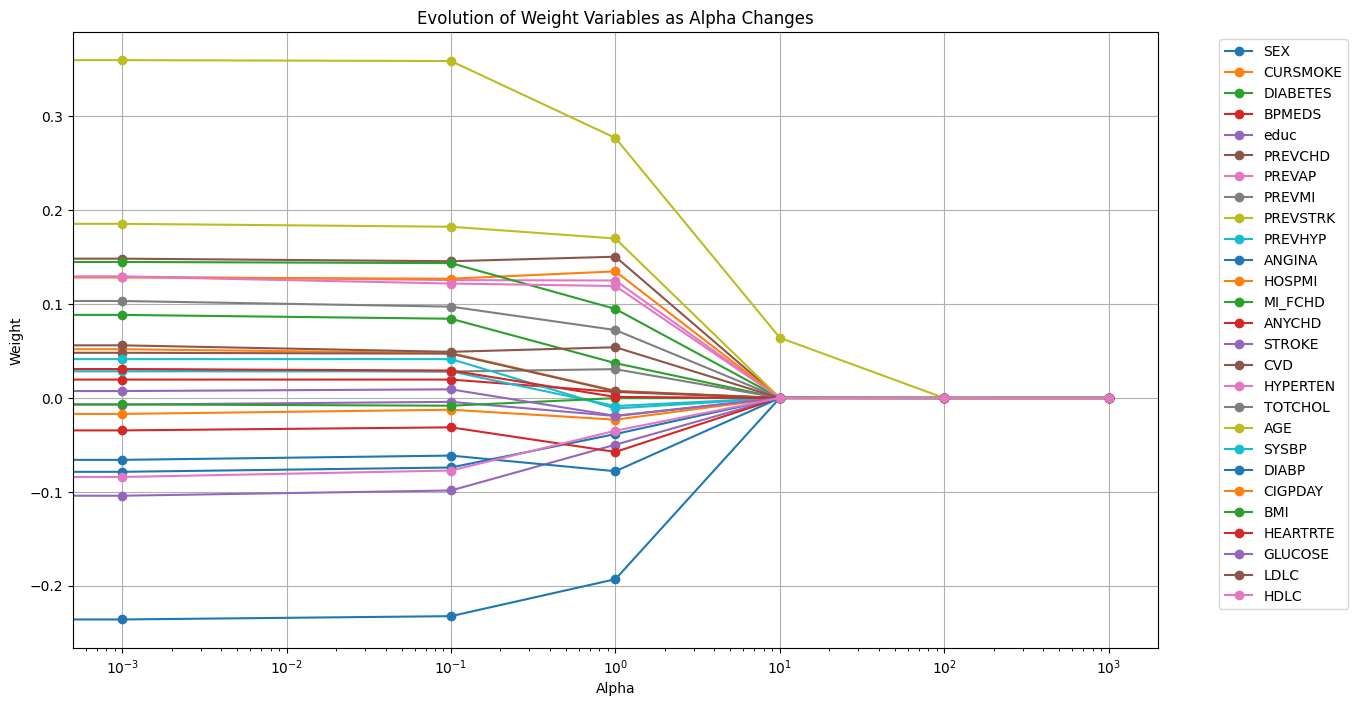

In [28]:
import matplotlib.pyplot as plt

flat_alphas = [alpha for sublist in alphas for alpha in sublist]

new_weights = []
for w in weights:
    new_weights.append(w.detach().numpy())

wxd = np.array(new_weights) 

plt.figure(figsize=(14, 8))
for i in range(len(x_tr.columns)):
    plt.plot(alphas, wxd[:, 0, i], marker='o', label=x_tr.columns[i])

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Weight')
plt.title('Evolution of Weight Variables as Alpha Changes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Ajuste la légende pour éviter le chevauchement
plt.grid(True)
plt.show()

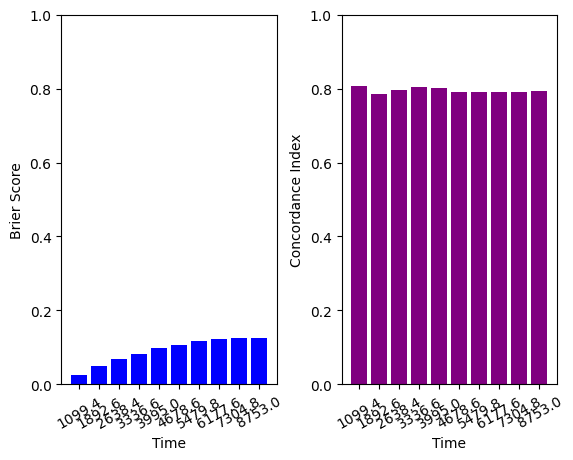

In [29]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

### Veterans Lung Cancer

In [217]:
#load veterans lung cancer
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()
data_y

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

In [218]:
data_x

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


In [17]:
#nan values
data_x.isnull().sum()

X200726_at      0
X200965_s_at    0
X201068_s_at    0
X201091_s_at    0
X201288_at      0
               ..
X221928_at      0
age             0
er              0
grade           0
size            0
Length: 80, dtype: int64

#### Cox - Cox L1

Text(0.5, 0, 'time $t$')

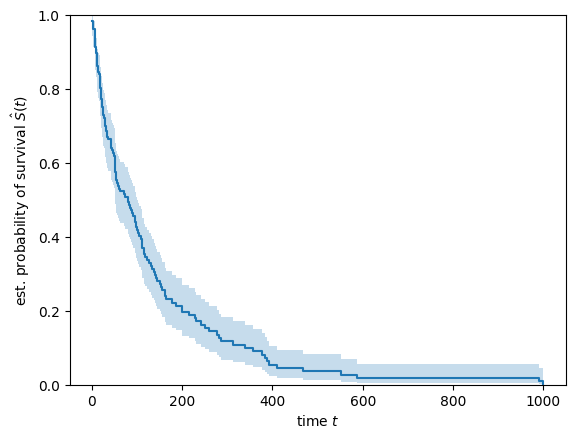

In [147]:
#Plot the Kaplan-Meier estimator
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["Status"], data_y["Survival_in_days"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [219]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head() #transform the categorical variables

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [224]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [150]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0] # Compute the concordance index

0.7362562471603816

In [225]:
y = pd.DataFrame(data_y, columns=["Status", "Survival_in_days"])
y["Status"] = y["Status"].astype(int)
#rename columns
y = y.rename(columns={"Status":"event","Survival_in_days":"time"})

In [166]:
data = pd.concat([data_x_numeric, y], axis=1)
data

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test,event,time
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0,1,72.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0,1,411.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0,1,228.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0,1,126.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0,1,118.0
...,...,...,...,...,...,...,...,...,...,...
132,65.0,1.0,0.0,0.0,75.0,1.0,0.0,1.0,1,133.0
133,64.0,1.0,0.0,0.0,60.0,5.0,0.0,1.0,1,111.0
134,67.0,1.0,0.0,0.0,70.0,18.0,1.0,1.0,1,231.0
135,65.0,1.0,0.0,0.0,80.0,4.0,0.0,1.0,1,378.0


In [167]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()

cph.fit(data, duration_col='time', event_col='event')

cph.print_summary()  # access the individual results using cph.summary

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -474.40
         time fit was run = 2024-05-13 07:48:25 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
Age_in_years          -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
Celltype=large        -0.79      0.45      0.30           -1.39           -0.20                0.25                0.82
Celltype=smallcell    -0.33      0.72      0.28           -0.88            0.21                0.42                1.23
Celltype=squamous     -1.20      0.30      0.30           -1.79           -0.61                0.17                0.55
Karnofsky_score       -0.03      0.97      0.01           -0.04           -0.02                0.96                0.98
Months_from_Diagnosis  0.00      1.00      0.01           -0.02            0.02                0.98                1.02
Prior_therapy=yes      0.07      1.07      0.23           -0.38            0.53                0.68                1.69
Treatment=test         0.29      1.34      0.21           -0.11            0.70                0.89                2.02

                       cmp to     z      p  -log2(p)
covariate                                           
Age_in_years             0.00 -0.94   0.35      1.52
Celltype=large           0.00 -2.62   0.01      6.85
Celltype=smallcell       0.00 -1.21   0.23      2.15
Celltype=squamous        0.00 -3.97 <0.005     13.79
Karnofsky_score          0.00 -5.96 <0.005     28.55
Months_from_Diagnosis    0.00  0.01   0.99      0.01
Prior_therapy=yes        0.00  0.31   0.76      0.40
Treatment=test           0.00  1.42   0.16      2.68
---
Concordance = 0.74
Partial AIC = 964.79
log-likelihood ratio test = 62.10 on 8 df
-log2(p) of ll-ratio test = 32.37

<Axes: xlabel='log(HR) (95% CI)'>

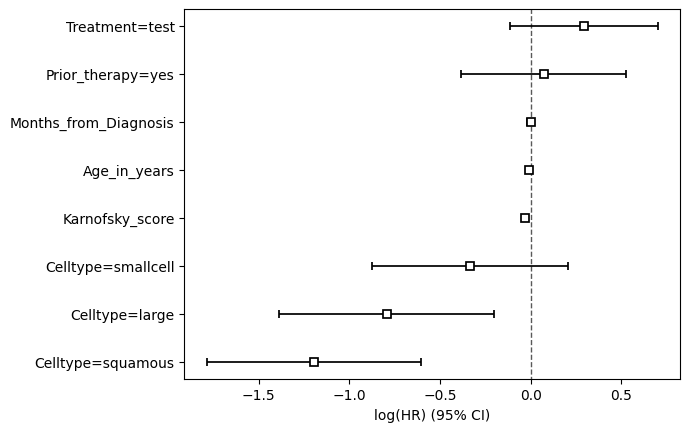

In [168]:
cph.plot() # Plot the coefficients

In [228]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(data_x_numeric, data_y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

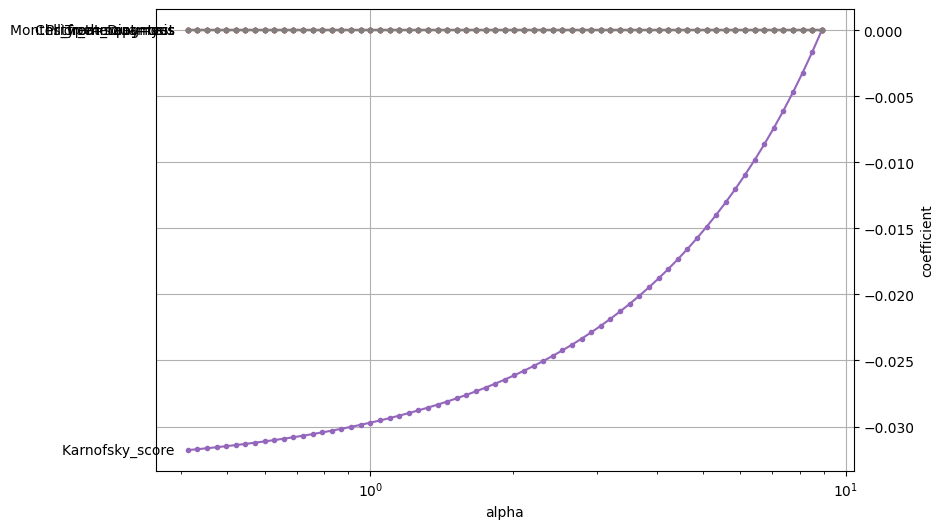

In [229]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=data_x_numeric.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=5)

In [230]:
coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio=0.01, max_iter=100)) 
warnings.simplefilter("ignore", UserWarning) 
warnings.simplefilter("ignore", FitFailedWarning) 
coxnet_pipe.fit(data_x_numeric, data_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1,
                                        max_iter=100))])

In [231]:
# Perform grid search with cross-validation
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(data_x_numeric, data_y)

cv_results = pd.DataFrame(gcv.cv_results_)

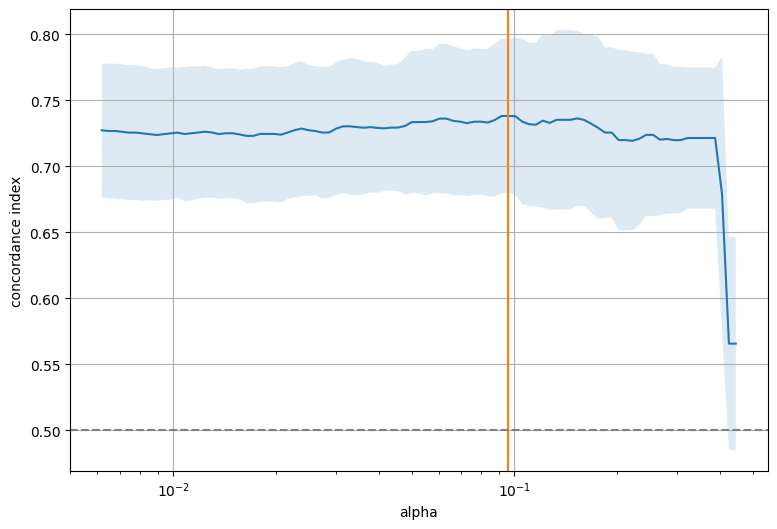

In [232]:
# Plot the results
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 4


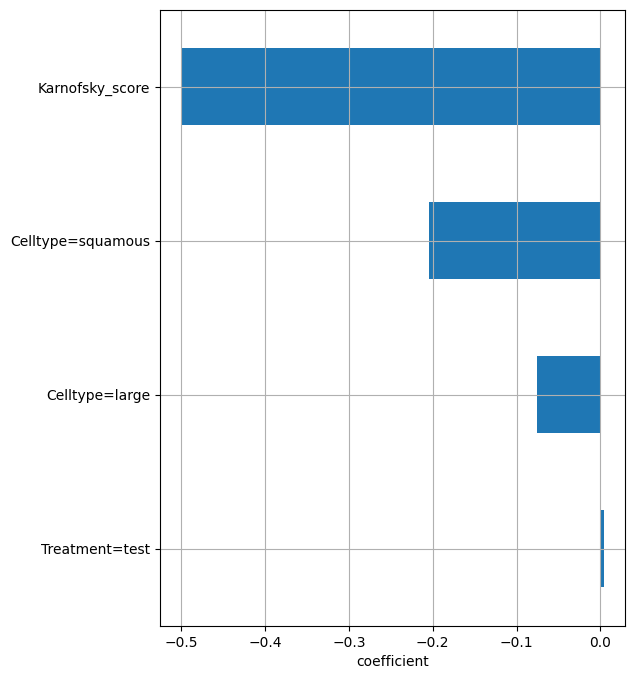

In [233]:
# Display the best model
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=data_x_numeric.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

#### Deep Cox

In [159]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(data, y, test_size=0.2, random_state=2001)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=2001) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
print(f'Number of test data points: {len(x_te)}')

Number of training data points: 81
Number of validation data points: 28
Number of test data points: 28


In [ ]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

print(x_tr.dtypes)
#print(y_tr)

# Define parameters for tuning the model
param_grid = {'k' : [2,3],
              'learning_rate' : [1e-3,1e-4]
              # 'layers' : [[100], [100, 100]],
             }

alphas = [[0], [0.001], [0.1], [1], [10], [100], [1000]]
params = ParameterGrid(param_grid)
weights = []

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()
#replace last value in times list with 9108 value
times[-1] = 9109
print(times)

# Perform hyperparameter tuning 
models = []
for alpha in alphas:
    for param in params:
        # model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'], layers=param['layers'], alphas=alphas)
        model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'],layers=[] ,alphas=alpha)
        
        # The fit method is called to train the model
        model.fit(x_tr, y_tr)
    
        # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
        predictions_val = model.predict_survival(x_val, times)
        metric_val = survival_regression_metric('brs', y_val, predictions_val, times, y_tr)
        models.append([metric_val, model])
    weight = model._model.torch_model[0].expert.weight
    weights.append(weight)
    
print(weights)
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

In [ ]:
import matplotlib.pyplot as plt

flat_alphas = [alpha for sublist in alphas for alpha in sublist]

new_weights = []
for w in weights:
    new_weights.append(w.detach().numpy())

wxd = np.array(new_weights) 

plt.figure(figsize=(14, 8))
for i in range(len(x_tr.columns)):
    plt.plot(alphas, wxd[:, 0, i], marker='o', label=x_tr.columns[i])

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Weight')
plt.title('Evolution of Weight Variables as Alpha Changes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Ajuste la légende pour éviter le chevauchement
plt.grid(True)
plt.show()

In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

## Donneur-receveur